<a href="https://colab.research.google.com/github/MasoudMoeini/Google-Street-View-Images-Blur-Detection/blob/main/GoogLeNet_SBDN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
from PIL import Image
from tensorflow import keras
from keras.models import Sequential, Model,load_model
from keras import layers
from keras import regularizers
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from keras.layers import Concatenate

In [9]:
!unzip -qq images.zip

In [10]:
!unzip -qq labels.zip

In [2]:
from numpy import *
images_folder= "images/*.jpg"
labels_folder = "labels/"
def data_preprocessing(images_folder,labels_folder):
  total_img = []
  class_label=[]
  label = []
  files = glob.glob (images_folder)
  for myFile in files[:3000]:
      image_name=os.path.split(myFile)[1]
      class_label.append(float(image_name[0]))
      image = array(Image.open(myFile))
      label_image = array(Image.open(labels_folder+image_name))
      label.append (label_image)
      total_img.append (image)
  total_img = np.array(total_img)
  label = np.array(label)
  class_label=np.array(class_label) 
  label= np.reshape(label,[label.shape[0],label.shape[1],label.shape[2],label.shape[3]])
  total_img= np.reshape(total_img,[total_img.shape[0],total_img.shape[1],total_img.shape[2],total_img.shape[3]])
  #np.save('class_labels', class_label)
  #np.save('total-images',total_img)
  #np.save('label-images',label)
  return class_label,label,total_img

In [3]:
class_labels,total_labels,total_images=data_preprocessing(images_folder,labels_folder)

In [4]:
def inception(x, filters):
    # 1x1
    path1 = Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)

    # 1x1->3x3
    path2 = Conv2D(filters=filters[1][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path2 = Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(path2)
    
    # 1x1->5x5
    path3 = Conv2D(filters=filters[2][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path3 = Conv2D(filters=filters[2][1], kernel_size=(5,5), strides=1, padding='same', activation='relu')(path3)

    # 3x3->1x1
    path4 = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(x)
    path4 = Conv2D(filters=filters[3], kernel_size=(1,1), strides=1, padding='same', activation='relu')(path4)

    return Concatenate(axis=-1)([path1,path2,path3,path4])

In [3]:
def auxiliary(x, name=None):
    layer = AveragePooling2D(pool_size=(5,5), strides=3, padding='valid')(x)
    layer = Conv2D(filters=128, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Flatten()(layer)
    layer = Dense(units=256, activation='relu')(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=1, activation='softmax', name=name)(layer)
    return layer


In [5]:
def identifier(x,name=None):
  layer = layers.Conv2DTranspose(1024, (3, 3), strides=(1, 1), padding='same',activation="relu")(x)
  layer = layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same',activation="relu")(layer)
  layer = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same',activation="relu")(layer)
  layer = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same',activation="relu")(layer)
  layer = layers.Conv2DTranspose(3, (3, 3), strides=(2, 2), padding='same',activation="relu")(layer)
  layer = layers.Conv2DTranspose(3, (3, 3), strides=(2, 2), padding='same',activation="relu")(layer)
  layer = layers.Conv2DTranspose(3, (3, 3), strides=(1, 1), padding='same',activation="sigmoid")(layer)
  layer = layers.Conv2DTranspose(3, (3, 3), strides=(1, 1), padding='same',activation="sigmoid",name=name)(layer)
  return layer


In [6]:
def googlenet():
    layer_in = Input(shape=(224, 224, 3))
    
    # stage-1
    layer = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(layer_in)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    layer = BatchNormalization()(layer)

    # stage-2
    layer = Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)

    # stage-3
    layer = inception(layer, [ 64,  (96,128), (16,32), 32]) #3a
    layer = inception(layer, [128, (128,192), (32,96), 64]) #3b
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-4
    layer = inception(layer, [192,  (96,208),  (16,48),  64]) #4a
  
    layer = inception(layer, [160, (112,224),  (24,64),  64]) #4b
    layer = inception(layer, [128, (128,256),  (24,64),  64]) #4c
    layer = inception(layer, [112, (144,288),  (32,64),  64]) #4d
    
    layer = inception(layer, [256, (160,320), (32,128), 128]) #4e
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-5
    layer = inception(layer, [256, (160,320), (32,128), 128]) #5a
    layer = inception(layer, [384, (192,384), (48,128), 128]) #5b
    ident  = identifier(layer, name='ident')
    layer = AveragePooling2D(pool_size=(7,7), strides=1, padding='valid')(layer)
    
    # stage-6
    layer = Flatten()(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=256, activation='linear')(layer)
    main = Dense(units=1, activation='softmax', name='main')(layer)
    
    model = Model(inputs=layer_in, outputs=[main,ident])
    
    return model

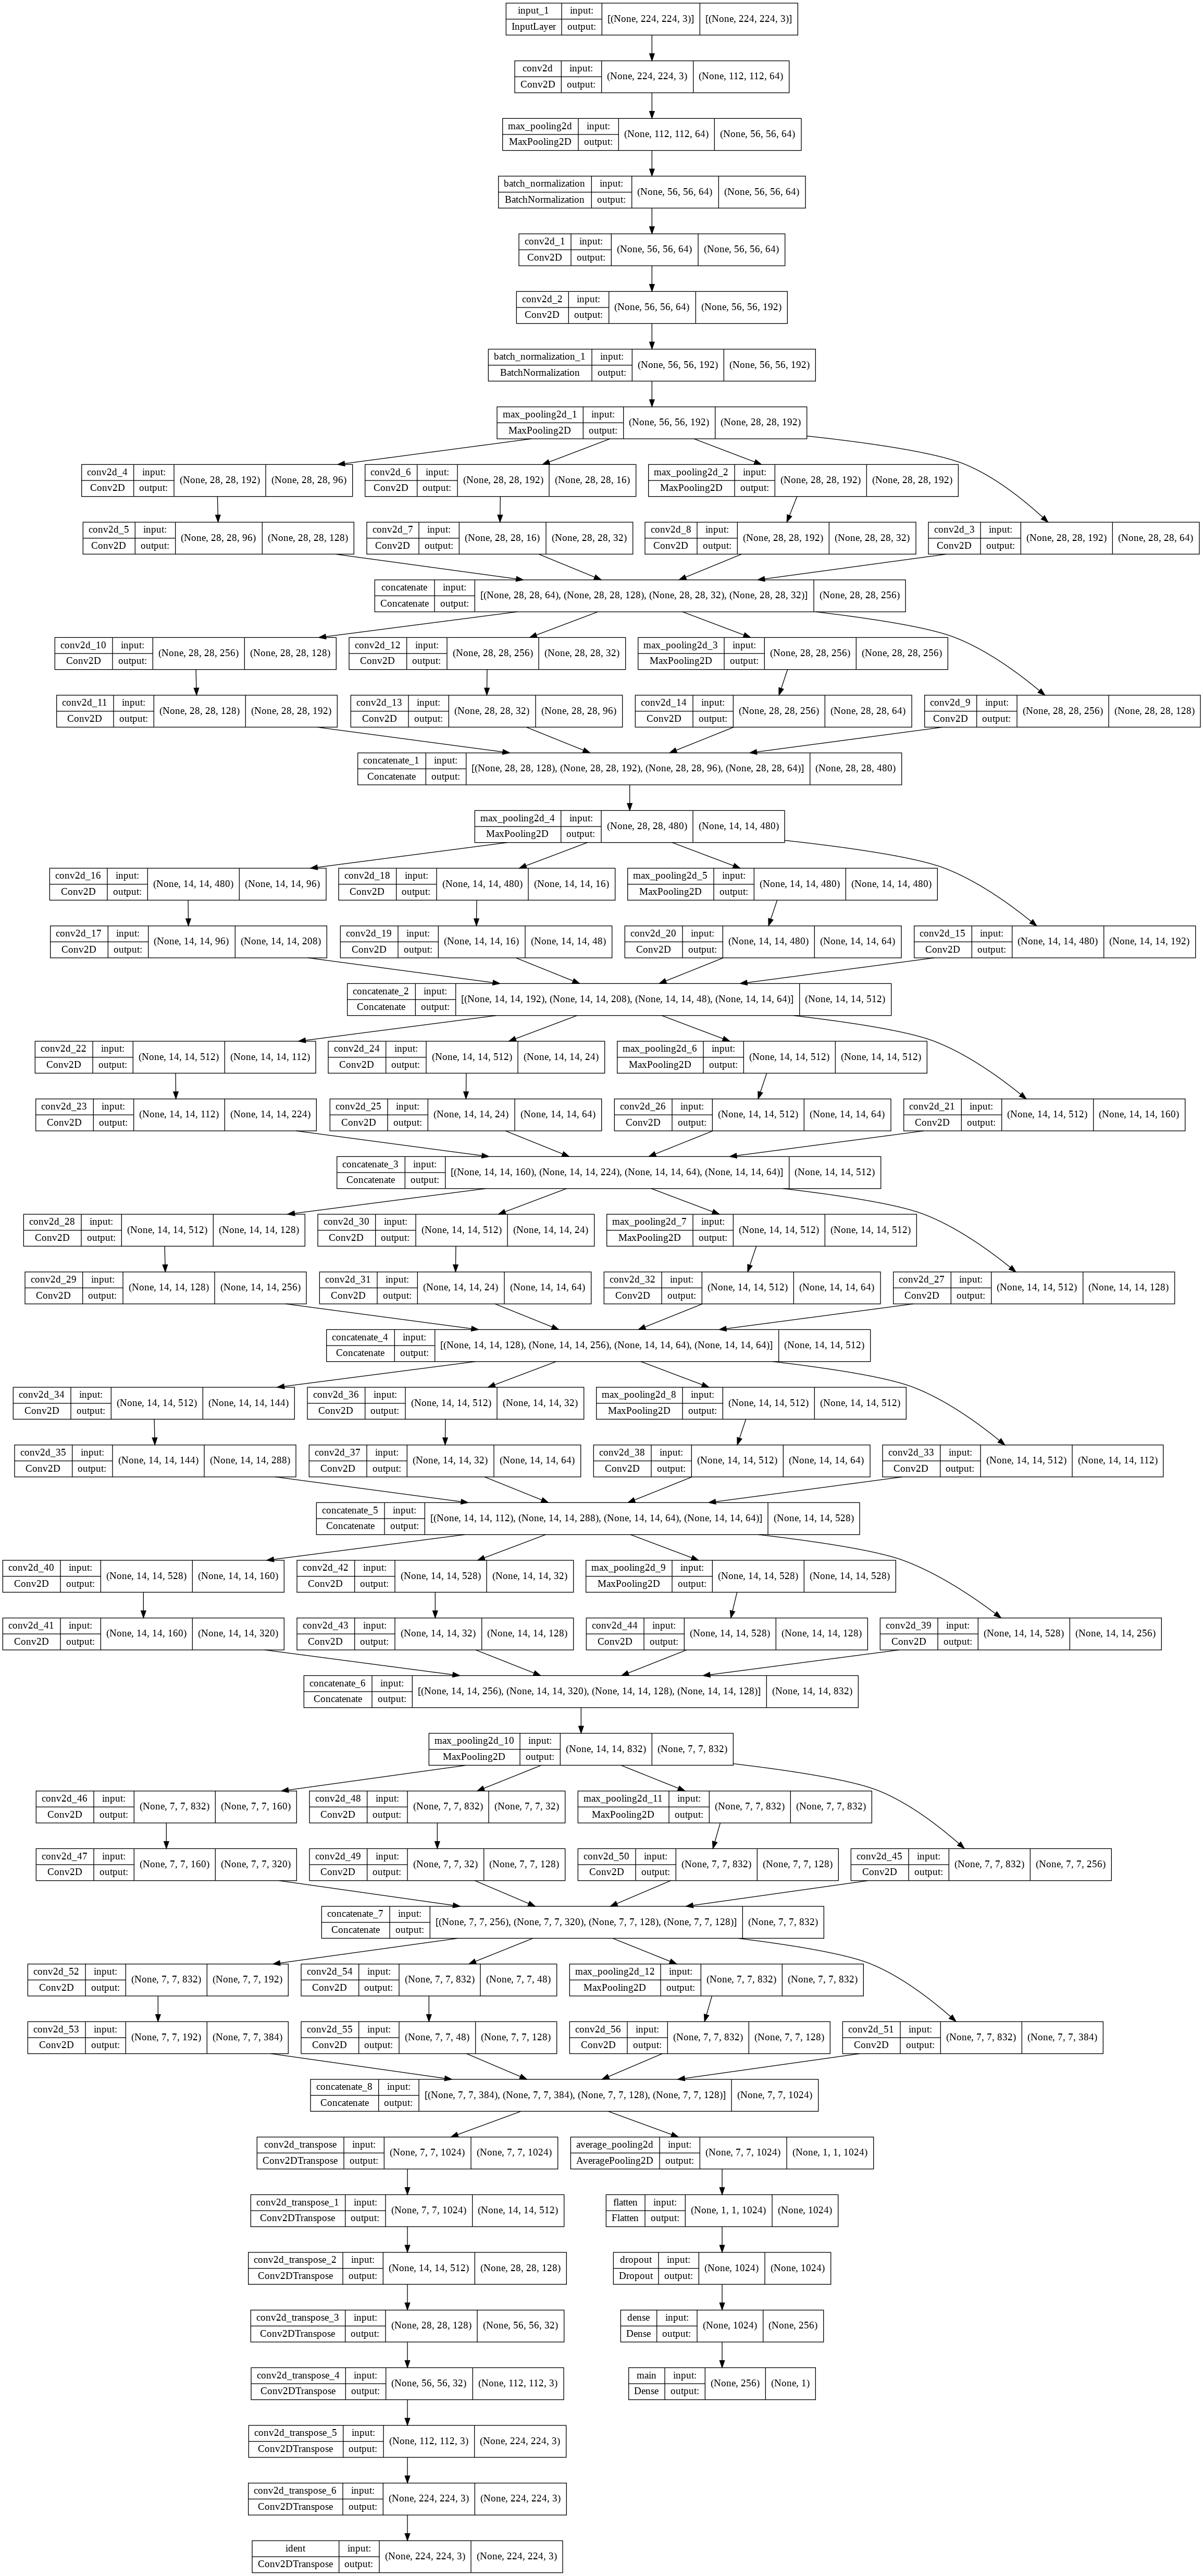

In [7]:
model = googlenet()
keras.utils.plot_model(model, show_shapes=True)

In [57]:
ACCURACY_THRESHOLD = 0.96
class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('val_main_accuracy') > ACCURACY_THRESHOLD):
			print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))
			self.model.stop_training = True

# Instantiate a callback object
callbacks = myCallback()

In [8]:
loss1="binary_crossentropy"
loss2=tf.keras.losses.MeanSquaredError()
model.compile(keras.optimizers.Adam(learning_rate=1e-3),loss = [loss1,loss2],metrics=["accuracy"])

In [9]:
class_label=class_labels[:2500]
x_train = total_images[:2500].astype(np.float32)/ 255.0
y_train=total_labels[:2500].astype(np.float32)/ 255.0
y_train =(y_train,class_label)

In [61]:
(y_train[0][0]).shape

(224, 224, 3)

In [10]:
history = model.fit(x_train,[y_train[1],y_train[0]], epochs=5,batch_size=20, validation_split=0.2,shuffle=True)
model.save('googleNet_model.h5')

Epoch 1/5
100/100 [==============================] - 36s 186ms/step - loss: 0.8631 - main_loss: 0.7393 - ident_loss: 0.1238 - main_accuracy: 0.5125 - ident_accuracy: 0.0292 - val_loss: 0.7756 - val_main_loss: 0.6931 - val_ident_loss: 0.0824 - val_main_accuracy: 0.4900 - val_ident_accuracy: 0.0142
Epoch 2/5
100/100 [==============================] - 15s 150ms/step - loss: 0.7719 - main_loss: 0.6948 - ident_loss: 0.0770 - main_accuracy: 0.5125 - ident_accuracy: 0.0027 - val_loss: 0.7753 - val_main_loss: 0.6940 - val_ident_loss: 0.0813 - val_main_accuracy: 0.4900 - val_ident_accuracy: 4.7832e-04
Epoch 3/5
100/100 [==============================] - 16s 161ms/step - loss: 0.7706 - main_loss: 0.6941 - ident_loss: 0.0765 - main_accuracy: 0.5125 - ident_accuracy: 5.5788e-04 - val_loss: 0.7747 - val_main_loss: 0.6934 - val_ident_loss: 0.0813 - val_main_accuracy: 0.4900 - val_ident_accuracy: 7.5733e-04
Epoch 4/5
100/100 [==============================] - 16s 161ms/step - loss: 0.7709 - main_loss

In [45]:
eval_images=total_images[2500:]
eval_labels=total_labels[2500:]
eval_class_label=class_labels[2500:]

In [46]:
from keras.models import load_model
from PIL import Image
#images = np.load('test-blurry-images.npy')
images = eval_images
model = load_model("googleNet_model.h5")
predictions=[]
for i in range(images.shape[0]):
  img = images[i]
  img = img.astype(np.float32)/ 255.0
  img = np.expand_dims(img, -1)
  img = np.expand_dims(img, 0)
  pred = model.predict(img)
  predictions.append(pred)

In [47]:
predictions[0][0]

array([[0.51145357]], dtype=float32)

In [48]:
y_pred_class=[]
for i in range(len(predictions)):
  predicted_class=(((predictions[i])[0])[0])[0]
  if (predicted_class>0.5):
    predicted_class=1.0
  else:
    predicted_class=0.0
  y_pred_class.append(predicted_class)
y_pred_class=np.array(y_pred_class)

In [50]:
#y_pred_class

In [52]:
#eval_class_label

Confusion Matrix

In [40]:
from sklearn.metrics import classification_report, confusion_matrix
conf_m = confusion_matrix(eval_class_label, y_pred_class)
conf_m

array([[ 0, 52],
       [ 0, 48]])

In [41]:
report = classification_report(eval_class_label, y_pred_class)
print(report)

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        52
         1.0       0.48      1.00      0.65        48

    accuracy                           0.48       100
   macro avg       0.24      0.50      0.32       100
weighted avg       0.23      0.48      0.31       100



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Intersection over Union

In [26]:
def get_iou_score(predictions,eval_labels):
  iou_scores=[]
  for i in range(len(predictions)):
    true_label = eval_labels[i]/255.0
    y_pred_label = np.where((((predictions[i])[1])[0])>0.5,1.0,0.0)
    m = tf.keras.metrics.MeanIoU(num_classes=2)
    m.update_state(true_label, y_pred_label)
    iou_scores.append(m.result().numpy())
  return mean(iou_scores)

In [27]:
iou_score = get_iou_score(predictions,eval_labels)
print('Average Intersection over Union IoU for Blur Detection: ',iou_score )

Average Intersection over Union IoU for Blur Detection:  0.69963527
